# Nearest Neighbor Search: Retrieving Related Wikipedia Profiles
*Natural Language Processing Project*

When reading an article of your interest it can be useful to get a list of similar articles. This is often a feature in many newsletter websites where in the end of an article you can find a couple more reading suggestions in effort to make the reader keep on reading articles on the website.

In a similar way we could look at Wikipedia pages most similar to a person of interest, as former U.S President Barack Obama's page.
But, when exploring a large set of documents such as Wikipedia to find relevant documents you typically need to decide on a notion of similarity and find the documents that are most similar. 

As mentioned above this text retrieval concept can be useful also to search similar articles, but also resumés, products, songs, etc...

## Import Packages & Load Wikipedia Dataset
Acknoledgment: The dataset was given by the University of Washington in the Machine Learning Specialization. It can also be found in [Kaggle](https://www.kaggle.com/sameersmahajan/people-wikipedia-data) in a older version. 

The dataset consists of: link to the wikipedia article (URI) , the name of person, the text of article (in lowercase).

Note: For the interest of computation time, the dataset given contains excerpts of the article rather than full text.

In [1]:
import turicreate
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

wiki_people = turicreate.SFrame('people_wiki.sframe')
wiki_people

URI,name,text
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


In [2]:
wiki_people.shape

(59071, 3)

## Extracting the Word Count vectors
Getting the word counts for each person's article text.

In [3]:
wiki_people['word_count'] = turicreate.text_analytics.count_words(wiki_people['text'])
wiki_people.head(5)

URI,name,text,word_count
<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'melbourne': 1.0,'parade': 1.0, ..."
<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'time': 1.0, 'each':1.0, 'hour': 1.0, ..."
<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'society': 1.0,'hamilton': 1.0, 'to': ..."
<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'kurdlawitzpreis': 1.0,'awarded': 1.0, '2004': ..."
<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'curtis': 1.0, '2007':1.0, 'cent': 1.0, ..."


## Find Nearest Neighbors
A) Finding Nearest Neighbors of Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance.

In [4]:
knn = turicreate.nearest_neighbors.create(wiki_people, label='name', features=['word_count'],
                                          method='brute_force', distance='euclidean')

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

The top 10 nearest neighbors:

In [7]:
knn.query(wiki_people[wiki_people['name']=='Barack Obama'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 53.071ms     |

| Done         |         | 100         | 1.29s        |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,0.0,1
Barack Obama,Joe Biden,33.075670817082454,2
Barack Obama,George W. Bush,34.39476704383968,3
Barack Obama,Lawrence Summers,36.15245496505044,4
Barack Obama,Mitt Romney,36.16628264005025,5
Barack Obama,Francisco Barrio,36.3318042491699,6
Barack Obama,Walter Mondale,36.40054944640259,7
Barack Obama,Wynn Normington Hugh-Jones ...,36.49657518178932,8
Barack Obama,Don Bonker,36.6333181680284,9
Barack Obama,Andy Anstett,36.959437225152655,10


At a glance, we can see the word counts got some things right, for example showing Joe Biden (Obama's vice president) and George W.Bush (former President of the U.S before Obama's presidency) as closely related. 
Also, after reading each of the 10 people profile we know all of them are politicians, but other than this fact not all of them present significant relation to Obama. 

Let's investigate why a weakly related politicians, as Andy Anstett and Francisco Barrio were considered in the list. What are the most frequently used words in Obama, Barrio and Anstett's pages?

In [39]:
def top_words(name):
    """
    Return table with words frequency in a given wiki page.
    """
    row = wiki_people[wiki_people['name'] == name]
    top_words_count = row[['word_count']].stack('word_count', new_column_name=['word', 'count'])
    return top_words_count.sort('count', ascending=False)

In [37]:
obama = top_words('Barack Obama')
anstett = top_words('Andy Anstett')
barrio = top_words('Francisco Barrio')

top_words = obama.join(anstett, on='word')
top_words = top_words.join(barrio, on='word')
top_words = top_words.rename({'count':'Obama', 'count.1':'Anstett', 'count.1.1':'Barrio'})

top_words

word,Obama,Anstett,Barrio
the,40.0,34.0,36.0
of,18.0,18.0,24.0
and,21.0,16.0,18.0
in,30.0,25.0,17.0
he,7.0,11.0,10.0
to,14.0,9.0,9.0
a,7.0,7.0,6.0
his,11.0,3.0,5.0
as,6.0,8.0,5.0
from,3.0,2.0,4.0


Doing the same for Joe Biden and George W. Bush's pages.

In [40]:
biden = top_words('Joe Biden')
bush = top_words('George W. Bush')

top_words = obama.join(biden, on='word')
top_words = top_words.join(bush, on='word')
top_words = top_words.rename({'count':'Obama', 'count.1':'Biden', 'count.1.1':'Bush'})

top_words

word,Obama,Biden,Bush
the,40.0,33.0,39.0
in,30.0,16.0,22.0
and,21.0,19.0,14.0
of,18.0,12.0,14.0
to,14.0,11.0,11.0
he,7.0,7.0,8.0
his,11.0,5.0,6.0
a,7.0,6.0,6.0
president,4.0,5.0,6.0
as,6.0,2.0,6.0


This model was able to list politicians even though common words are not emphasizing rarer political words. However, the pausible results appear to be for the wrong reasons. 

To find the most relevant articles, let's focus on the rare words that will distinguish the article from any other. 

## Extracting the Word Count vectors (TF-IDF)
Getting the word count while penalizing words that are too common using the TF-IDF representation.

In [41]:
wiki_people['tf_idf'] = turicreate.text_analytics.tf_idf(wiki_people['word_count'])
wiki_people.head(5)

Columns:
	URI	str
	name	str
	text	str
	word_count	dict
	tf_idf	dict

Rows: 5

Data:
+-------------------------------+---------------------+
|              URI              |         name        |
+-------------------------------+---------------------+
| <http://dbpedia.org/resour... |    Digby Morrell    |
| <http://dbpedia.org/resour... |    Alfred J. Lewy   |
| <http://dbpedia.org/resour... |    Harpdog Brown    |
| <http://dbpedia.org/resour... | Franz Rottensteiner |
| <http://dbpedia.org/resour... |        G-Enka       |
+-------------------------------+---------------------+
+-------------------------------+-------------------------------+
|              text             |           word_count          |
+-------------------------------+-------------------------------+
| digby morrell born 10 octo... | {'melbourne': 1.0, 'parade... |
| alfred j lewy aka sandy le... | {'time': 1.0, 'each': 1.0,... |
| harpdog brown is a singer ... | {'society': 1.0, 'hamilton... |
| franz rottensteiner born i... | {'kurdlawitzpreis': 1.0, '... |
| henry krvits born 30 decem... | {'curtis': 1.0, '2007': 1.... |
+-------------------------------+-------------------------------+
+-------------------------------+
|             tf_idf            |
+-------------------------------+
| {'melbourne': 3.8914310119... |
| {'time': 1.325334207420049... |
| {'society': 2.444804726208... |
| {'kurdlawitzpreis': 10.986... |
| {'curtis': 5.2995200328853... |
+-------------------------------+
[5 rows x 5 columns]

B) Finding Nearest Neighbors of Barack Obama page using the word count vectors (tf-idf) to represent the articles and Euclidean distance to measure distance.

In [42]:
knn_tf_idf = turicreate.nearest_neighbors.create(wiki_people, label='name', features=['tf_idf'],
                                                 method='brute_force', distance='euclidean')

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

In [43]:
knn_tf_idf.query(wiki_people[wiki_people['name']=='Barack Obama'], label='name', k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 20.393ms     |

| Done         |         | 100         | 781.01ms     |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
Barack Obama,Barack Obama,0.0,1
Barack Obama,Phil Schiliro,106.86101369140928,2
Barack Obama,Jeff Sessions,108.87167421571077,3
Barack Obama,Jesse Lee (politician),109.04569790902957,4
Barack Obama,Samantha Power,109.10810616502708,5
Barack Obama,Bob Menendez,109.78186710530214,6
Barack Obama,Eric Stern (politician),109.9577880796839,7
Barack Obama,James A. Guest,110.41388871759888,8
Barack Obama,Roland Grossenbacher,110.47060870018983,9
Barack Obama,Tulsi Gabbard,110.69699799880009,10


Except for Roland Grossenbacher the remaining people are all American politicians. Also, 4 of the listed politicians worked for Obama. This already shows improvement from our first knn model. 

Let's investigate the top_words as we did before.

In [51]:
def top_words_tf_idf(name):
    """
    Return table with words frequency in a given wiki page.
    """
    row = wiki_people[wiki_people['name'] == name]
    top_words_count = row[['tf_idf']].stack('tf_idf', new_column_name=['word', 'weight']) #TF-IDF weights
    return top_words_count.sort('weight', ascending=False)

In [53]:
obama = top_words_tf_idf('Barack Obama')
schiliro = top_words_tf_idf('Phil Schiliro')

top_words = obama.join(schiliro, on='word')
top_words = obama.rename({'weight':'Obama', 'weight.1':'Schiliro'})
top_words.sort('Obama', ascending=False)
top_words

word,weight,weight.1
obama,43.2956530720749,9.621256238238866
law,14.722935761763422,7.361467880881711
democratic,12.410688697332166,6.205344348666083
senate,10.164288179703693,3.3880960599012306
presidential,7.386955418904825,3.6934777094524125
president,7.226869291326606,9.033586614158258
policy,6.095386282141427,3.0476931410707135
states,5.473200989631017,1.824400329877006
office,5.2481728232196465,2.6240864116098233
2011,5.107041270312876,3.4046941802085837


Comparing A and B model. How common are the top words considering all the articles in this Wikipedia dataset?

In [57]:
common_words = ['the', 'in', 'and', 'of', 'to']
def has_words(count_vector):
    unique_words = set(count_vector.keys())
    if set(common_words).issubset(unique_words): return True
    else: return False
    
wiki_people['has_top_words'] = wiki_people['word_count'].apply(has_words)
print('Articles with common words:',wiki_people[wiki_people['has_top_words'] == 1].num_rows())

Articles with common words: 56066


In [58]:
common_words = ['obama', 'law', 'democratic', 'senate', 'presidential'] #tf-idf

wiki_people['has_top_words_tf_idf'] = wiki_people['tf_idf'].apply(has_words)
print('Articles with common words (tf-idf):',wiki_people[wiki_people['has_top_words_tf_idf'] == 1].num_rows())

Articles with common words (tf-idf): 14


A lot of noise coming from the extremely common words has been eliminated using TD-IDF word representation. From 56066 articles now we have 14 contains the top common words.  

It's weird that Joe Biden is not in the list. Let's investigate why Joe Biden is not in the list resulted from td-idf representation.

In [59]:
obama_tf_idf = wiki_people[wiki_people['name']=='Barack Obama']['tf_idf'][0]
biden_tf_idf = wiki_people[wiki_people['name']=='Joe Biden']['tf_idf'][0]
print('Obama/Biden:', turicreate.toolkits.distances.euclidean(obama_tf_idf, biden_tf_idf))

Obama/Biden: 123.29745600964294


The euclidean distance between Obama and Biden is larger by about 13 compared to the rank 10 from our knn_tf_idf model. 

How is Biden's article more different than Schiliro's from Obama? Let's have a look at the length of these Wiki articles.

In [61]:
def article_length(row):
    return len(row['text'].split(' '))

wiki_people['length'] = wiki_people.apply(article_length)

In [64]:
query_100nn = knn_tf_idf.query(wiki_people[wiki_people['name']=='Barack Obama'], label='name', k=100)
query_100nn = query_100nn.join(wiki_people[['name','length']], on={'reference_label':'name'})
query_100nn.sort('rank')

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 47.178ms     |

| Done         |         | 100         | 1.28s        |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank,length
Barack Obama,Barack Obama,0.0,1,540
Barack Obama,Phil Schiliro,106.86101369140928,2,208
Barack Obama,Jeff Sessions,108.87167421571077,3,230
Barack Obama,Jesse Lee (politician),109.04569790902957,4,216
Barack Obama,Samantha Power,109.10810616502708,5,310
Barack Obama,Bob Menendez,109.78186710530214,6,220
Barack Obama,Eric Stern (politician),109.9577880796839,7,255
Barack Obama,James A. Guest,110.41388871759888,8,215
Barack Obama,Roland Grossenbacher,110.47060870018983,9,201
Barack Obama,Tulsi Gabbard,110.69699799880009,10,228


Text(0, 0.5, 'Percentage (%)')

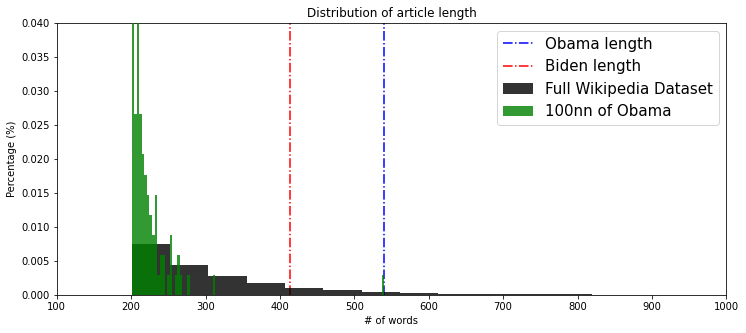

In [89]:
plt.figure(figsize=(12, 5))

plt.hist(wiki_people['length'], 100, label='Full Wikipedia Dataset', color='k', histtype='stepfilled', zorder=3, alpha=0.8, density=True)
plt.hist(query_100nn['length'], 100, label='100nn of Obama', color='g', histtype='stepfilled', zorder=4, alpha=0.8, density=True)

plt.axvline(x=wiki_people['length'][wiki_people['name']=='Barack Obama'][0], label='Obama length', color='b', linestyle='-.', zorder=1)
plt.axvline(x=wiki_people['length'][wiki_people['name']=='Joe Biden'][0], label='Biden length', color='r', linestyle='-.', zorder=2)
plt.axis([100, 1000,0,0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of article length')
plt.xlabel('# of words')
plt.ylabel('Percentage (%)')

The histogram suggests that when modeling nearest neighbors using euclidean distance there is a underlying favor to shorter articles over long ones as we can notice, there is a huge concentration of NN's on the shortest articles in the dataset (mostly below 300 words). While TF-IDF penalizes extremely common words, longer articles have a tendency to have longer TF-IDF vector simply because they have more words in the article.

To treat this bias, we can try cosine distance instead. Because, it let us compare word distributions of two articles of varying lengths. 

In [80]:
knn_tf_idf_cos = turicreate.nearest_neighbors.create(wiki_people, label='name', features=['tf_idf'],
                                                     method='brute_force', distance='cosine')

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

In [83]:
query_100nn_cos = knn_tf_idf_cos.query(wiki_people[wiki_people['name']=='Barack Obama'], label='name', k=100)
query_100nn_cos = query_cos.join(wiki_people[['name', 'length']], on={'reference_label':'name'})
query_100nn_cos.sort('rank')

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.00169288  | 62.049ms     |

| Done         |         | 100         | 1.45s        |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank,length,length.1
Barack Obama,Barack Obama,0.0,1,540,540
Barack Obama,Joe Biden,0.7031386767335749,2,414,414
Barack Obama,Samantha Power,0.7429819023278823,3,310,310
Barack Obama,Hillary Rodham Clinton,0.7583583978869676,4,580,580
Barack Obama,Eric Stern (politician),0.7705612276009977,5,255,255
Barack Obama,Robert Gibbs,0.7846775047506501,6,257,257
Barack Obama,Eric Holder,0.7880390729434777,7,232,232
Barack Obama,Jesse Lee (politician),0.7909264153663161,8,216,216
Barack Obama,Henry Waxman,0.7983226028934733,9,279,279
Barack Obama,Joe the Plumber,0.799466360041952,10,217,217


The difference is noticiably positive. 

Text(0, 0.5, 'Percentage (%)')

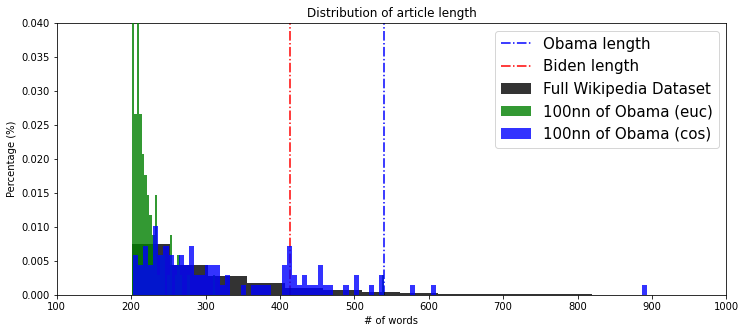

In [87]:
plt.figure(figsize=(12, 5))

plt.hist(wiki_people['length'], 100, label='Full Wikipedia Dataset', color='k', histtype='stepfilled', zorder=3, alpha=0.8, density=True)
plt.hist(query_100nn['length'], 100, label='100nn of Obama (euc)', color='g', histtype='stepfilled', zorder=4, alpha=0.8, density=True)
plt.hist(query_100nn_cos['length'], 100, label='100nn of Obama (cos)', color='b', histtype='stepfilled', zorder=5, alpha=0.8, density=True)

plt.axvline(x=wiki_people['length'][wiki_people['name']=='Barack Obama'][0], label='Obama length', color='b', linestyle='-.', zorder=1)
plt.axvline(x=wiki_people['length'][wiki_people['name']=='Joe Biden'][0], label='Biden length', color='r', linestyle='-.', zorder=2)
plt.axis([100,1000,0,0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of article length')
plt.xlabel('# of words')
plt.ylabel('Percentage (%)')

The graph above shows how the 100nn using cosine distance provided a better distribution across the range of documents lengths compared to the articles provided with euclidean distance. 

For this application tf-idf and cosine distance made sense but that is not always the case. Cosine distance ignores all document lengths, so that should be watched carefully when applied to another application. Enforcing maximum/minimum article lengths could prevent this issue to a certain extend. 